# Summary

In the first stage, we established that selecting a simple portfolio built with classical methods is more reliable than attempting to select or compose a portfolio using machine learning, in particular neural networks.

During the second stage, we wanted to establish whether adding more relevant features to the training data and reducing the problem to a simple forecast (of future covariance or future returns) is a viable strategy. If this does not improve the base model, it will confirm our hypothesis that portfolio allocation should be performed based on fundamentals of portfolio theory and economics, rather than based on advanced analytics and forecasting.

This summary consists of following parts:
1. Base model performance testing (classical portfolio theory)
2. Training advanced forecasting model
  - dataset assembly
  - model architecture definition
  - training & validation of created model
3. Building hybrid portfolios
4. Comparison of test results between portfolio strategies

## Base model performance

In [1]:
import pandas as pd
import numpy as np
pd.set_option('precision', 4)
pd.set_option('chop_threshold', 1e-15)

from numba import jit

from typing import Tuple

from utils.data_loader import *

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
class OneYearTest(object):
    """
    Scikit-learn style iterator returning training- and test-set indices,
    where test set is one-year-long and training set consists of n_train_years
    preceding the test set year.
    """
    def __init__(self, df: pd.DataFrame, n_train_years: int=10):
        self.index_years = df.index.year
        self.unique_years = np.unique(self.index_years)
        self.n_train_years = n_train_years
        
    @property
    def train_years(self):
        return set(self.unique_years[self.idx-self.n_train_years:self.idx])
    
    @property
    def test_year(self):
        return self.unique_years[self.idx]

    def __iter__(self):
        self.idx = self.n_train_years
        return self
    
    def __next__(self):
        if self.idx < len(self.unique_years):
            train_ids = self.index_years.isin(self.train_years)
            test_ids = self.index_years == self.test_year
            self.idx += 1
            return train_ids, test_ids
        else:
            raise StopIteration

In [3]:
@jit(nopython=True)
def portfolio_performance(allocation: np.array, fund_values: np.array) -> Tuple[float, float]:
    """
    Calculates total returns and daily returns volatility during entire period of provided fund values.
    """
    allocation_value = np.sum(allocation * fund_values, axis=1) / np.sum(allocation)
    period_returns = (allocation_value[-1] - allocation_value[0]) / allocation_value[0]
    daily_returns = (allocation_value[1:] - allocation_value[:-1]) / allocation_value[:-1]
    period_volatility = np.std(daily_returns)
    return period_returns, period_volatility

In [4]:
@jit(nopython=True)
def portfolio_srri(allocation: np.array, fund_values: np.array) -> int:
    """
    Calculates SRRI based on porfolio volatility 
    during last 5 years of provided fund_values,
    as described in https://bit.ly/2RDVib9
    """
    m = 260  # days in a year, as in the SRRI paper
    T = 5*260  # days in 5 years, as in the SRRI paper
    allocation_value = np.sum(allocation * fund_values[-T:], axis=1) / np.sum(allocation)
    daily_returns = (allocation_value[1:] - allocation_value[:-1]) / allocation_value[:-1]
    scaled_volatility = np.sqrt(m * np.sum((daily_returns - np.mean(daily_returns))**2) / (T-1))
    if scaled_volatility >= 0.25:
        return 7
    elif scaled_volatility >= 0.15:
        return 6
    elif scaled_volatility >= 0.1:
        return 5
    elif scaled_volatility >= 0.05:
        return 4
    elif scaled_volatility >= 0.02:
        return 3
    elif scaled_volatility >= 0.005:
        return 2
    else:
        return 1

In [5]:
def base_model(funds_df: pd.DataFrame) -> np.array:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_return(0.04)
    return ef.weights

### Loading data

In [6]:
funds_df = load_funds()
funds_df.head()

,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,
2000-01-03,415.90,549.11,354.45,401.26,275.08,520.13,230.72
2000-01-04,404.41,533.89,357.14,401.42,275.08,520.02,229.63
2000-01-05,400.04,527.38,351.19,401.59,275.08,519.22,229.22
2000-01-06,410.15,522.02,347.96,401.75,275.07,519.62,228.82
2000-01-07,429.16,533.16,351.87,401.93,275.07,520.80,230.09


### Evaluating model performance

In [7]:
result_dfs = []
for train_ids, test_ids in OneYearTest(funds_df):
    train_, test_ = funds_df[train_ids], funds_df[test_ids]
    allocation = base_model(train_)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    srri = portfolio_srri(allocation, train_.values)
    returns, volatility = portfolio_performance(allocation, test_.values)
    performance_data = {'srri': srri, 'returns': returns, 'volatility': volatility}
    result_dfs.append(
        pd.DataFrame({**allocation_data, **performance_data}, index=[test_.index.year[0]])
    )
base_results_df = pd.concat(result_dfs, axis='index')
base_results_df

,AP,ARR,ARW,G,OP,ORR,ORW,srri,returns,volatility
2010,0.0000e+00,0.0972,0.0000e+00,0.0300,0.0000e+00,0.8728,0.0000e+00,3,0.0398,0.0014
2011,0.0000e+00,0.0726,0.0000e+00,0.1379,0.0000e+00,0.7895,0.0000e+00,3,0.0491,0.0011
2012,0.0000e+00,0.0299,0.0000e+00,0.1635,0.0000e+00,0.8065,0.0000e+00,3,0.0389,0.0010
2013,0.0000e+00,0.0000,0.0000e+00,0.3964,9.8262e-02,0.5053,0.0000e+00,2,0.0075,0.0009
2014,0.0000e+00,0.0120,0.0000e+00,0.3697,1.7110e-01,0.4390,8.2929e-03,2,0.0574,0.0007
2015,0.0000e+00,0.0476,0.0000e+00,0.4063,1.3233e-01,0.4121,1.7235e-03,2,0.0065,0.0011
2016,0.0000e+00,0.0074,0.0000e+00,0.3376,2.0575e-01,0.3393,1.0993e-01,2,0.0209,0.0011
2017,0.0000e+00,0.0000,0.0000e+00,0.3130,2.3905e-01,0.3097,1.3827e-01,2,0.0291,0.0008
2018,0.0000e+00,0.0048,0.0000e+00,0.3070,2.3387e-01,0.3055,1.4884e-01,2,0.0075,0.0008


## Advanced model performance

We will attempt to train a deep neural network, that will attempt to predict future returns as well as future fund value covariance.

In [8]:
from dataclasses import dataclass, asdict
import multiprocessing as mp

from tqdm import tqdm

import ta

### External data

In the first stage of competitions, we downloaded a lot of seemingly useful data, but its volume was too large 
for any meaningful feature selection to be performed.

This time, we have carefully selected by hand the most important indices that may play a role in terms of forecasting
portfolio performance.

The data was manually downloaded from [Stooq](https://stooq.pl/).

In [9]:
external_data = load_stooq()

### Feature generation

For our fund values and index values downloaded above, we will calculate similar features to the ones mentioned by: 
*Bao, W., Yue, J., Rao, Y. (2017). A deep learning framework for financial time series
using stacked autoencoders and long-short term memory.*

Note, that most of the technical indicators can only be calculated for the downloaded index values,
as our fund values do not have open-high-low-close price & volume information attached to it.

In [10]:
fund_column_features = {
    'MACD': lambda col: ta.trend.macd(col, n_fast=80, n_slow=160),
    'BBL': lambda col: ta.volatility.bollinger_lband(col, n=120),
    'BBH': lambda col: ta.volatility.bollinger_hband(col, n=120),
    'EMA': lambda col: ta.trend.ema_indicator(col, n=240),
    'ID': lambda col: col
}

ohlc_df_features = {
    'MACD': lambda df: ta.trend.macd(df['Zamkniecie'], n_fast=80, n_slow=160),
    'BBL': lambda df: ta.volatility.bollinger_lband(df['Zamkniecie'], n=120),
    'BBH': lambda df: ta.volatility.bollinger_hband(df['Zamkniecie'], n=120),
    'EMA': lambda df: ta.trend.ema_indicator(df['Zamkniecie'], n=240),
    'SMI': lambda df: ta.momentum.stoch(
        high=df['Najwyzszy'],
        low=df['Najnizszy'],
        close=df['Zamkniecie'],
        n=160
    ),
    'ID': lambda df: df['Zamkniecie']
}

ohlc_volume_df_features = {
    'MFI': lambda df: ta.momentum.money_flow_index(
        high=df['Najwyzszy'],
        low=df['Najnizszy'],
        close=df['Zamkniecie'],
        volume=df['Wolumen'].fillna(df['Wolumen'].mean()),  # volumes often have missing values in our dataset
        n=120
    ),
    # this is always appended with ohlc_df_features => no 'ID' ("identity") feature is necessary
}

In [11]:
OHLC_COLUMNS = ['Otwarcie', 'Zamkniecie', 'Najwyzszy', 'Najnizszy']

features_df = pd.DataFrame(index=funds_df.index)
for col in tqdm(funds_df.columns, desc='Funds'):
    for key in fund_column_features:
        features_df[f'{col}_{key}'] = fund_column_features[key](funds_df[col])
        
for ext_df, idx_name in tqdm(external_data, desc='External data'):
    ext_df = ext_df.reindex(index=funds_df.index)
    # we forward-fill missing values to account for differences between trading days across the world
    ext_df[OHLC_COLUMNS] = ext_df[OHLC_COLUMNS].fillna(method='ffill')
    for key in ohlc_df_features:
        if '3m' in idx_name and key not in {'MACD', 'EMA', 'ID'}:
            # for central bank interest rates, only calculate these 3 features
            continue
        features_df[f'{idx_name}_{key}'] = ohlc_df_features[key](
            ext_df.fillna(method='ffill')
        )
    if 'Wolumen' in ext_df.columns:
        for key in ohlc_volume_df_features:
            features_df[f'{idx_name}_{key}'] = ohlc_volume_df_features[key](ext_df)
print(features_df.shape)

External data: 100%|██████████| 8/8 [00:00<00:00,  8.90it/s]

(4801, 77)


### Target generation

In [12]:
@dataclass
class Target(object):
    fund_returns: np.array
    fund_covariance: np.array
    ideal_allocation: np.array
    ideal_returns: float

In [13]:
def calculate_target(funds_df: pd.DataFrame) -> Target:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.1)
    ideal_allocation = ef.weights
    ideal_returns = ef.portfolio_performance()[0]
    return Target(mu, S, ideal_allocation, ideal_returns)

We calculate all target data in parallel to save time:

In [14]:
%%time
YEAR_DAYS = 260

dfs = [
    funds_df[idx+1 : idx+1+YEAR_DAYS]
    for idx in range(funds_df.iloc[:-YEAR_DAYS].shape[0])
]
with mp.Pool(processes=12) as pool:
    targets = pool.map(calculate_target, dfs)

print(len(targets))

4541
CPU times: user 5.3 s, sys: 324 ms, total: 5.62 s
Wall time: 28.1 s


Then, we extract information necessary for our experiment and back it up:

In [15]:
returns_target = np.zeros_like(funds_df[:-YEAR_DAYS])
covariance_target = np.zeros(
    (len(funds_df[:-YEAR_DAYS]), funds_df.shape[1]**2)
)
sample_weights = np.zeros(len(funds_df[:-YEAR_DAYS]))

for idx, target in enumerate(targets):
    returns_target[idx] = target.fund_returns.values.ravel()
    covariance_target[idx] = target.fund_covariance.values.ravel()
    sample_weights[idx] = target.ideal_returns  # years with higher returns are more important

np.save('data/forecasting/returns_target.npy', returns_target)
np.save('data/forecasting/covariance_target.npy', covariance_target)
np.save('data/forecasting/sample_weights.npy', sample_weights)

We can also add past targets to our features:

In [16]:
returns_features = np.zeros_like(funds_df)
returns_features[:YEAR_DAYS] = np.nan
returns_features[YEAR_DAYS:] = returns_target

covariance_features = np.zeros(
    (len(funds_df), funds_df.shape[1]**2)
)
covariance_features[:YEAR_DAYS] = np.nan
covariance_features[YEAR_DAYS:] = covariance_target

weights_features = np.zeros(len(funds_df))
weights_features[:YEAR_DAYS] = np.nan
weights_features[YEAR_DAYS:] = sample_weights

### Model definition

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

assert(torch.cuda.is_available())
cuda_device = 0
torch.cuda.empty_cache()

In [18]:
class LSTM(nn.Module):
    """
    Most basic LSTM regression model.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2, cuda_device=cuda_device):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.cuda_device = cuda_device

        self.lstm = nn.LSTM(
            self.input_dim, 
            self.hidden_dim, 
            self.num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32)
        )
        return self.hidden

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input)
        # shape of lstm_out: [batch_size, seq_len, hidden_dim]
        y_pred = self.linear(lstm_out[:,-1].view(self.batch_size, -1))
        return y_pred.view(-1)

### Training & evaluation

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [20]:
all_features = np.hstack([features_df.values, returns_features, covariance_features, weights_features.reshape(-1, 1)])
features_valid = np.all(~np.isnan(all_features), axis=1)
feature_scaler = MinMaxScaler()
all_features[features_valid] = feature_scaler.fit_transform(all_features[features_valid])

all_targets = np.hstack([returns_target, covariance_target])
targets_valid = np.all(~np.isnan(all_targets), axis=1)
target_scaler = StandardScaler()
all_targets[targets_valid] = target_scaler.fit_transform(all_targets[targets_valid])

# unlike features, targets are only generated when they are valid
assert(sum(targets_valid) == len(targets_valid))
assert(len(targets_valid) < len(features_valid))

# this is created for one-year-validation to have a correct index for data splitting
meta_df = pd.DataFrame(columns=['features_valid', 'target_valid'], index=funds_df.index)
meta_df['features_valid'].iloc[:len(features_valid)] = features_valid
meta_df['target_valid'].iloc[:len(targets_valid)] = targets_valid
meta_df.fillna(False, inplace=True)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
all_features.shape, all_targets.shape

((4801, 134), (4541, 56))

In [22]:
def as_sequences(
        X: np.array, 
        y: np.array, 
        seq_len: int, 
        batch_size: int, 
        cuda_device: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Allocates GPU memory for features and labels, 
    making sure they are in correct shape for LSTM:
    X: (n_batches, batch_size, sequence_length, n_features)
    y: (n_batches, batch_size, n_targets)
    """
    assert(len(X) == len(y))
    
    n_samples, n_features = X.shape
    n_targets = y.shape[1]
    n_batches = (n_samples-seq_len) // batch_size
    X_seqs = np.zeros((n_batches, batch_size, seq_len, n_features))
    y_labels = np.zeros((n_batches, batch_size, n_targets))
    for batch_idx in range(n_batches):
        X_seqs[batch_idx] = np.reshape(
            np.array([X[idx:idx+seq_len] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, seq_len, n_features)
        )
        y_labels[batch_idx] = np.reshape(
            np.array([y[idx+seq_len-1] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, n_targets)
        )
    return torch.from_numpy(X_seqs).to(cuda_device).type(torch.float32), torch.from_numpy(y_labels).to(cuda_device).type(torch.float32)

#### Training parameters

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [24]:
n_epochs = 8
lr = 0.0002
model_hidden_dim = 80
seq_len = 2*YEAR_DAYS
val_set_len = YEAR_DAYS
batch_size = 1  # WARNING: Other sizes may not work right now

In [25]:
def train(model, X_train_, y_train_, X_valid_, y_valid_, n_epochs: int=n_epochs):
    model.to(cuda_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.MSELoss()
    train_loss_vals = np.zeros(n_epochs)
    eval_loss_vals = np.zeros(n_epochs)
    for ep_idx in range(n_epochs):
        model.init_hidden()
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_train_, y_train_)), 
                total=len(X_train_), 
                desc=f'Training epoch={ep_idx+1}/{n_epochs}'):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss_val = loss(y_pred, y_batch)
            train_loss_vals[ep_idx] += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_loss_vals[ep_idx] = train_loss_vals[ep_idx] / len(X_train_)  # average training loss
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_valid_, y_valid_)), 
                total=len(X_valid_), 
                desc=f'Validating epoch={ep_idx+1}/{n_epochs}'):
            with torch.no_grad():
                y_pred = model(X_batch)
                loss_val = loss(y_pred, y_batch)
                eval_loss_vals[ep_idx] += loss_val.item()
        eval_loss_vals[ep_idx] = eval_loss_vals[ep_idx] / len(X_valid_)
    return model, train_loss_vals, eval_loss_vals

In [26]:
def predict_allocate(model, X, transformer, n_funds=7):
    with torch.no_grad():
        # reshape preserves dimensions when batch_size=1
        y_pred = model(X).reshape(len(X), -1).cpu().numpy()
    y_last_pred = transformer.inverse_transform(y_pred[-1])
    mu = y_last_pred[:n_funds]
    S = y_last_pred[n_funds:].reshape((n_funds, n_funds))
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.09)  # 0.01 threshold for safety
    # normalizing output in case scaling and 32bit casts for GPU
    # altered it resulting in allocation of more than 100% of portfolio
    weights = normalize([ef.weights])[0]
    return weights

Skipping iteration with test_year=2010 due to lack of valid features in training set:
Valid features: 2270, required: 2530
Skipping iteration with test_year=2011 due to lack of valid features in training set:
Valid features: 2525, required: 2533


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 81.36it/s]


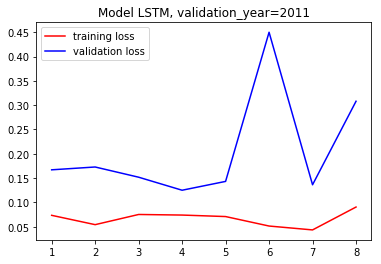

              AP     ARR         ARW       G      OP     ORR         ORW  \
2012  1.4036e-12  0.0322  5.0800e-12  0.4607  0.8732  0.1558  3.6663e-14   

      srri  returns  volatility  
2012     2   0.0922      0.0009  


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 81.69it/s]


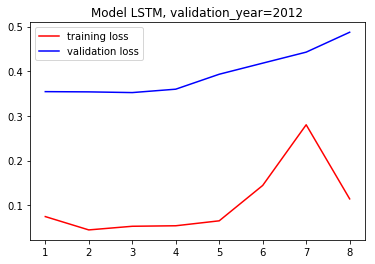

              AP         ARR         ARW       G      OP     ORR     ORW  \
2013  2.6294e-11  2.4703e-11  2.9087e-11  0.7236  0.4892  0.4265  0.2348   

      srri  returns  volatility  
2013     2   0.0039      0.0012  


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 80.87it/s]


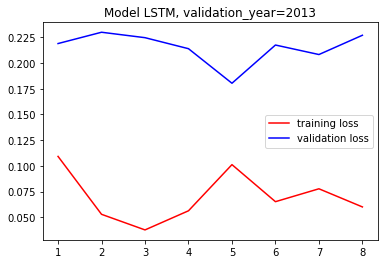

          AP     ARR         ARW       G      OP  ORR         ORW  srri  \
2014  0.1749  0.8141  0.0000e+00  0.5471  0.0854  0.0  0.0000e+00     4   

      returns  volatility  
2014   0.0353       0.003  


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 81.89it/s]


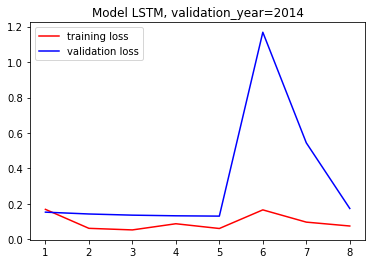

              AP     ARR         ARW       G      OP     ORR     ORW  srri  \
2015  0.0000e+00  0.3112  0.0000e+00  0.6673  0.6172  0.0902  0.2622     3   

      returns  volatility  
2015   0.0054      0.0016  


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 81.58it/s]


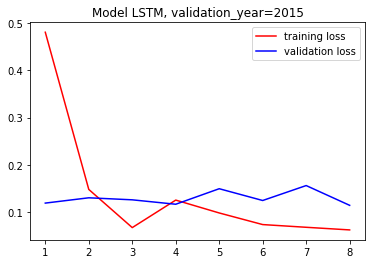

              AP         ARR         ARW    G   OP  ORR  ORW  srri  returns  \
2016  6.3249e-14  2.9066e-12  9.8525e-14  0.0  0.0  1.0  0.0     3   0.0222   

      volatility  
2016      0.0021  


Validating epoch=8/8: 100%|██████████| 259/259 [00:03<00:00, 81.62it/s]


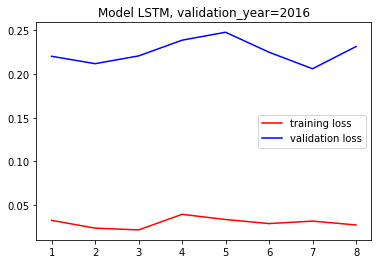

       AP         ARR         ARW    G   OP     ORR    ORW  srri  returns  \
2017  0.0  4.7477e-14  3.3821e-15  0.0  0.0  0.3092  0.951     3   0.0746   

      volatility  
2017      0.0015  
Skipping iteration with test_year=2018 due to lack of valid targets in training set:
Valid targets: 2520, required: 2528


,AP,ARR,ARW,G,OP,ORR,ORW,srri,returns,volatility
2012,1.4036e-12,3.2173e-02,5.0800e-12,0.4607,0.8732,0.1558,3.6663e-14,2,0.0922,0.0009
2013,2.6294e-11,2.4703e-11,2.9087e-11,0.7236,0.4892,0.4265,2.3476e-01,2,0.0039,0.0012
2014,1.7493e-01,8.1410e-01,0.0000e+00,0.5471,0.0854,0.0000,0.0000e+00,4,0.0353,0.0030
2015,0.0000e+00,3.1116e-01,0.0000e+00,0.6673,0.6172,0.0902,2.6223e-01,3,0.0054,0.0016
2016,6.3249e-14,2.9066e-12,9.8525e-14,0.0000,0.0000,1.0000,0.0000e+00,3,0.0222,0.0021
2017,0.0000e+00,4.7477e-14,3.3821e-15,0.0000,0.0000,0.3092,9.5101e-01,3,0.0746,0.0015


In [27]:
models = []
result_dfs = []
assert((meta_df.index == funds_df.index).all())
for train_ids, test_ids in OneYearTest(meta_df):  # TODO: Support batch_size other than 1 in OneYearTest
    test_year = meta_df[test_ids].index.year[0]
    if not meta_df.iloc[train_ids]['features_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid features in training set:")
        print(f"Valid features: {meta_df.iloc[train_ids]['features_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['features_valid'])}")
        continue
    if not meta_df.iloc[train_ids]['target_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid targets in training set:")
        print(f"Valid targets: {meta_df.iloc[train_ids]['target_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['target_valid'])}")
        continue
    X, y = all_features[train_ids[:len(all_features)]], all_targets[train_ids[:len(all_targets)]]
    assert(~np.any(np.isnan(X)))
    assert(~np.any(np.isnan(y)))
    
    X, y = as_sequences(X, y, seq_len=seq_len, batch_size=batch_size, cuda_device=cuda_device)
    X_train_ = X[:-val_set_len]
    y_train_ = y[:-val_set_len]
    X_valid_ = X[-val_set_len:-1]
    y_valid_ = y[-val_set_len:-1]
    X_test_batch_ = X[-1]  # for portfolio construction, separate from validation
    
    model = LSTM(
        input_dim=all_features.shape[1], 
        hidden_dim=model_hidden_dim,
        output_dim=all_targets.shape[1],
        batch_size=1
    )
    model, train_loss, valid_loss = train(model, X_train_, y_train_, X_valid_, y_valid_)
    models.append(model)
    x = list(range(1,n_epochs+1))
    plt.plot(x, train_loss, color='red', label='training loss')
    plt.plot(x, valid_loss, color='blue', label='validation loss')
    plt.title(f'Model {model.__class__.__name__}, validation_year={meta_df[train_ids].index.year[-1]}')
    plt.legend()
    plt.show()
    
    allocation = predict_allocate(model, X_test_batch_, target_scaler)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    srri = portfolio_srri(allocation, funds_df[train_ids].values)
    returns, volatility = portfolio_performance(allocation, funds_df[test_ids].values)
    performance_data = {'srri': srri, 'returns': returns, 'volatility': volatility}
    performance_df = pd.DataFrame(
        {**allocation_data, **performance_data}, 
        index=[meta_df[test_ids].index.year[0]]
    )
    print(performance_df)
    result_dfs.append(performance_df)
lstm_results_df = pd.concat(result_dfs, axis='index')
lstm_results_df

## Hybrid approaches

Having trained model, we can easily check whether mixing its output with the base model imporoves results.

To do this, we will test predictions of a models that take either returns or covariance forecast from the LSTM.

In [45]:
def hybrid_model(model, X, transformer, funds_df, use_from_lstm='covariance'):
    """
    Generates weights based on both LSTM and classical portfolio theory.
    Specify one of:
    - use_from_lstm='covariance'
    - use_from_lstm='returns'
    """
    n_funds = funds_df.shape[1]
    with torch.no_grad():
        # reshape preserves dimensions when batch_size=1
        y_pred = model(X).reshape(len(X), -1).cpu().numpy()
    y_last_pred = transformer.inverse_transform(y_pred[-1])
    if use_from_lstm == 'covariance':
        mu = mean_historical_return(funds_df)
        S = y_last_pred[n_funds:].reshape((n_funds, n_funds))
    elif use_from_lstm == 'returns':
        mu = y_last_pred[:n_funds]
        S = CovarianceShrinkage(funds_df).ledoit_wolf()
    else:
        raise TypeError('Bad parameter')
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.09)  # 0.01 threshold for safety
    # normalizing output in case scaling and 32bit casts for GPU
    # altered it resulting in allocation of more than 100% of portfolio
    weights = normalize([ef.weights])[0]
    return weights

In [52]:
result_dfs = []
assert((meta_df.index == funds_df.index).all())
model_idx = 0
for train_ids, test_ids in OneYearTest(meta_df):
    test_year = meta_df[test_ids].index.year[0]
    if not meta_df.iloc[train_ids]['features_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid features in training set:")
        print(f"Valid features: {meta_df.iloc[train_ids]['features_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['features_valid'])}")
        continue
    if not meta_df.iloc[train_ids]['target_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid targets in training set:")
        print(f"Valid targets: {meta_df.iloc[train_ids]['target_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['target_valid'])}")
        continue
    X, y = all_features[train_ids[:len(all_features)]], all_targets[train_ids[:len(all_targets)]]
    assert(~np.any(np.isnan(X)))
    assert(~np.any(np.isnan(y)))
    
    X, y = as_sequences(X, y, seq_len=seq_len, batch_size=batch_size, cuda_device=cuda_device)
    X_train_ = X[:-val_set_len]
    y_train_ = y[:-val_set_len]
    X_valid_ = X[-val_set_len:-1]
    y_valid_ = y[-val_set_len:-1]
    X_test_batch_ = X[-1]  # for portfolio construction, separate from validation
    
    model = models[model_idx]
    model_idx += 1
    
    hybrid_allocs = [
        hybrid_model(model, X_test_batch_, target_scaler, funds_df[train_ids], use_from_lstm='returns'),
        hybrid_model(model, X_test_batch_, target_scaler, funds_df[train_ids], use_from_lstm='covariance'),
    ]
    performance_dfs = []
    for allocation, name in zip(hybrid_allocs, ['LSTM-RET', 'LSTM-COV']):
        allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
        srri = portfolio_srri(allocation, funds_df[train_ids].values)
        returns, volatility = portfolio_performance(allocation, funds_df[test_ids].values)
        performance_data = {'srri': srri, 'returns': returns, 'volatility': volatility}
        performance_df = pd.DataFrame(
            {**allocation_data, **performance_data}, 
            index=[meta_df[test_ids].index.year[0]]
        )
        performance_dfs.append(performance_df.add_suffix(f'_{name}'))
    result_dfs.append(pd.concat(performance_dfs, axis='columns'))
hybrid_results_df = pd.concat(result_dfs, axis='index')
hybrid_results_df

Skipping iteration with test_year=2010 due to lack of valid features in training set:
Valid features: 2270, required: 2530
Skipping iteration with test_year=2011 due to lack of valid features in training set:
Valid features: 2525, required: 2533
Skipping iteration with test_year=2018 due to lack of valid targets in training set:
Valid targets: 2520, required: 2528


,AP_LSTM-RET,ARR_LSTM-RET,ARW_LSTM-RET,G_LSTM-RET,OP_LSTM-RET,ORR_LSTM-RET,ORW_LSTM-RET,srri_LSTM-RET,returns_LSTM-RET,volatility_LSTM-RET,AP_LSTM-COV,ARR_LSTM-COV,ARW_LSTM-COV,G_LSTM-COV,OP_LSTM-COV,ORR_LSTM-COV,ORW_LSTM-COV,srri_LSTM-COV,returns_LSTM-COV,volatility_LSTM-COV
2012,3.5739e-12,5.8303e-03,8.9403e-12,9.9400e-01,1.0075e-01,4.2216e-02,3.2947e-12,1,0.0485,0.0002,3.1500e-09,3.0639e-09,3.6866e-09,0.2245,0.5787,0.0871,0.7792,3,0.1298,0.0012
2013,0.0000e+00,0.0000e+00,0.0000e+00,9.6645e-01,2.3036e-01,1.0372e-01,4.6331e-02,2,0.0168,0.0006,0.0000e+00,0.0000e+00,0.0000e+00,0.8556,0.2727,0.3141,0.3081,2,0.0025,0.0011
2014,2.3331e-02,1.4062e-01,0.0000e+00,9.6535e-01,2.1858e-01,4.4800e-14,0.0000e+00,2,0.0322,0.0007,2.6192e-02,0.0000e+00,5.1957e-02,0.9588,0.2495,0.0553,0.1099,2,0.0345,0.0007
2015,0.0000e+00,4.8528e-02,0.0000e+00,8.7028e-01,4.6664e-01,1.4983e-01,7.6104e-03,2,0.0078,0.0008,5.8535e-03,2.3322e-02,2.9726e-02,0.9246,0.2788,0.1407,0.2147,2,0.0052,0.0008
2016,6.0086e-13,1.2089e-11,7.1301e-13,1.0627e-13,5.2211e-12,1.0000e+00,2.2379e-13,3,0.0222,0.0021,1.1851e-14,6.0480e-15,1.8822e-14,0.8432,0.4391,0.0241,0.3092,2,0.0221,0.0010
2017,0.0000e+00,2.1443e-14,8.1952e-15,0.0000e+00,0.0000e+00,7.1216e-01,7.0201e-01,3,0.0514,0.0014,0.0000e+00,0.0000e+00,0.0000e+00,0.8484,0.4563,0.1206,0.2397,2,0.0313,0.0005


## Results comparison

In [59]:
combined_results = base_results_df.add_suffix('_BASE') \
        .join(lstm_results_df.add_suffix('_LSTM')) \
        .join(hybrid_results_df).dropna(axis='index')

In [61]:
combined_summary = combined_results[[
    col for col in combined_results.columns
    if 'srri' in col or 'returns' in col or 'volatility' in col
]]
combined_summary

,srri_BASE,returns_BASE,volatility_BASE,srri_LSTM,returns_LSTM,volatility_LSTM,srri_LSTM-RET,returns_LSTM-RET,volatility_LSTM-RET,srri_LSTM-COV,returns_LSTM-COV,volatility_LSTM-COV
2012,3,0.0389,0.0010,2.0,0.0922,0.0009,1.0,0.0485,0.0002,3.0,0.1298,0.0012
2013,2,0.0075,0.0009,2.0,0.0039,0.0012,2.0,0.0168,0.0006,2.0,0.0025,0.0011
2014,2,0.0574,0.0007,4.0,0.0353,0.0030,2.0,0.0322,0.0007,2.0,0.0345,0.0007
2015,2,0.0065,0.0011,3.0,0.0054,0.0016,2.0,0.0078,0.0008,2.0,0.0052,0.0008
2016,2,0.0209,0.0011,3.0,0.0222,0.0021,3.0,0.0222,0.0021,2.0,0.0221,0.0010
2017,2,0.0291,0.0008,3.0,0.0746,0.0015,3.0,0.0514,0.0014,2.0,0.0313,0.0005


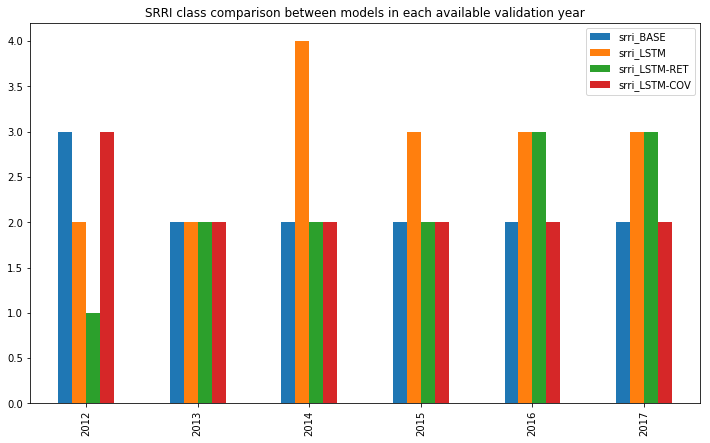

In [72]:
combined_summary[[col for col in combined_summary.columns if 'srri' in col]].plot(kind='bar', figsize=(12,7))
plt.title("SRRI class comparison between models in each available validation year")
plt.show()

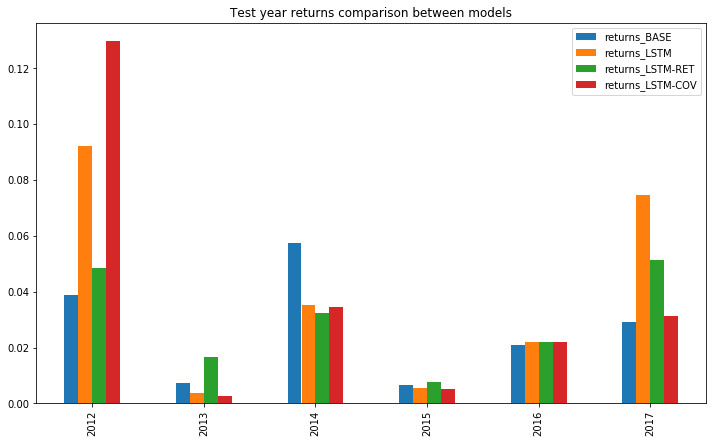

In [74]:
combined_summary[[col for col in combined_summary.columns if 'returns' in col]].plot(kind='bar', figsize=(12,7))
plt.title("Test year returns comparison between models")
plt.show()

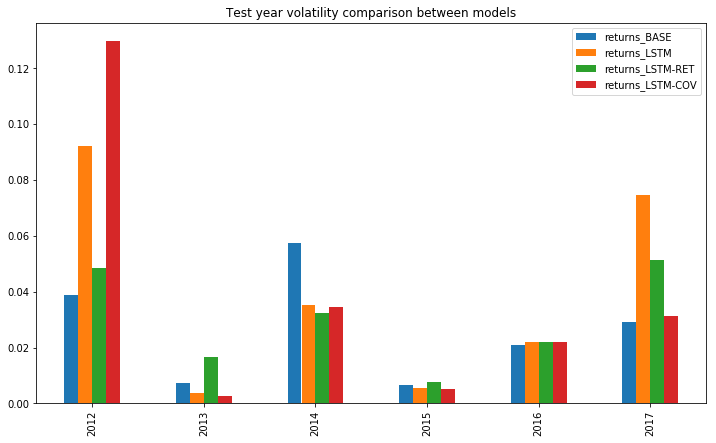

In [75]:
combined_summary[[col for col in combined_summary.columns if 'returns' in col]].plot(kind='bar', figsize=(12,7))
plt.title("Test year volatility comparison between models")
plt.show()

**We can see that, on average, LSTM-based portfolio strategies often outperform base portfolio strategy, 
but they are also a little riskier (while still within the limits of SRRI no greater than 4).**

## Saving models & data

Targets were saved as soon as generated, other data is relatively fast to compute and there is no need for saving it.

Results are saved only for easier comparison in the future.

In [76]:
for idx, model in enumerate(models):
    torch.save(model.state_dict(), f'data/forecasting/model_{idx}.pt')

In [78]:
combined_results.to_csv('data/forecasting/results_summary.csv')